<div class="alert alert-block alert-info">
    
# META LEARNING<a class="anchor"><a id='toc'></a></a><br>
* [<font color='#E8800A'>Importing Libraries</font>](#first-bullet) <br>
- [<font color='#E8800A'>Fetching Data from OpenML Repository</font>](#second-bullet) <br>
- [<font color='#E8800A'>Building the Meta Database</font>](#third-bullet)<br>
- [<font color='#E8800A'>Exploratory Data Analysis & Preprocessing</font>](#forth-bullet)<br>
- [<font color='#E8800A'>Metadata Extraction Algorithm</font>](#fifth-bullet)<br>
- [<font color='#E8800A'>Predicting a Dataset's Model and Pipeline</font>](#sixth-bullet)<br>
    
    
    
</div>

# <font color='#E8800A'>Importing Libraries</font> <a class="anchor" id="first-bullet"></a>
  [Back to META LEARNING](#toc)

In [1]:
import openml
import pandas as pd
import numpy as np
import scipy.stats
import random
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

from openml import evaluations, datasets, tasks, runs, flows, config

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sys
# Use conda's XGBoost installation which has proper OpenMP support
sys.path.insert(0, '/Users/lyinderswale/miniconda/lib/python3.13/site-packages')
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn import svm


import warnings
warnings.filterwarnings("ignore")

---------------

In [ ]:
# 🗂️ Dataset Caching System - Speeds up re-runs significantly!

import os
import pickle
import time
from pathlib import Path

# Create cache directory
CACHE_DIR = Path("openml_cache")
CACHE_DIR.mkdir(exist_ok=True)

def get_cached_data(cache_key, fetch_function, *args, **kwargs):
    """
    Universal caching function for OpenML data
    
    Args:
        cache_key: Unique identifier for cached data
        fetch_function: Function to call if cache miss
        *args, **kwargs: Arguments to pass to fetch_function
    """
    cache_file = CACHE_DIR / f"{cache_key}.pkl"
    
    # Check if cache exists and is recent (modify max_age as needed)
    if cache_file.exists():
        # Get cache age in hours
        cache_age_hours = (time.time() - cache_file.stat().st_mtime) / 3600
        
        if cache_age_hours < 720:  # Cache valid for 30 days (720 hours)
            print(f"📋 Loading from cache: {cache_key} (age: {cache_age_hours:.1f}h)")
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        else:
            print(f"🕐 Cache expired: {cache_key} (age: {cache_age_hours:.1f}h)")
    
    # Cache miss - fetch fresh data
    print(f"🌐 Fetching fresh data: {cache_key}")
    data = fetch_function(*args, **kwargs)
    
    # Save to cache
    with open(cache_file, 'wb') as f:
        pickle.dump(data, f)
    print(f"💾 Saved to cache: {cache_key}")
    
    return data

def cached_dataset_list():
    """Cached version of openml.datasets.list_datasets()"""
    return openml.datasets.list_datasets()

def cached_dataset_qualities(dataset_ids):
    """Cached version of dataset qualities extraction"""
    def fetch_qualities():
        complex_ = []
        h = []
        for i in dataset_ids:
            h.append(i)
            try:
                qualities = openml.datasets.get_dataset(i).qualities
                complex_.append(qualities)
                print(f"✅ {len(h)}/{len(dataset_ids)} - did {i}")
            except Exception as e:
                print(f"❌ {len(h)}/{len(dataset_ids)} - did {i} - Error: {e}")
                complex_.append({})  # Empty dict for failed downloads
        return complex_
    
    return fetch_qualities()

def clear_cache():
    """Clear all cached data"""
    import shutil
    if CACHE_DIR.exists():
        shutil.rmtree(CACHE_DIR)
        CACHE_DIR.mkdir(exist_ok=True)
        print("🗑️ Cache cleared!")



🚀 Caching system ready!
📁 Cache directory: /Users/lyinderswale/Desktop/openml_cache
💡 Benefits:
  • Faster re-runs (seconds vs minutes)
  • Offline capability once cached
  • Automatic cache expiration (30 days)
  • Error resilience with partial caching


# <font color='#E8800A'>Extracting Data from OPENML Repository</font> <a class="anchor" id="second-bullet"></a>
  [Back to META LEARNING](#toc)

### Query 1: Extracting basic meta features

In [3]:
# 🚀 Extracting datasets basic data from OpenML Repository (WITH CACHING!)

# Use cached version - much faster on subsequent runs!
openml_list = get_cached_data(
    cache_key="basic_dataset_list",
    fetch_function=cached_dataset_list
)

dataset = pd.DataFrame.from_dict(openml_list, orient="index")

basic_df = dataset.dropna().reset_index().drop(columns ='index')
print(f"📊 Loaded {len(basic_df)} datasets from OpenML")

📋 Loading from cache: basic_dataset_list (age: 9.8h)
📊 Loaded 1220 datasets from OpenML


In [4]:
basic_df.tail()

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
1215,42172,regime_alimentaire,1,4030,active,ARFF,161.0,7.0,41.0,2.0,20.0,202.0,17.0,17.0,3.0,17.0
1216,42186,JuanFeldmanIris,1,10443,active,ARFF,50.0,3.0,50.0,3.0,5.0,150.0,0.0,0.0,4.0,1.0
1217,42192,compas-two-years,3,10483,active,ARFF,2795.0,2.0,2483.0,2.0,14.0,5278.0,0.0,0.0,7.0,7.0
1218,42193,compas-two-years,4,10483,active,ARFF,2795.0,2.0,2483.0,2.0,14.0,5278.0,0.0,0.0,7.0,7.0
1219,42206,porto-seguro,2,1475,active,ARFF,573518.0,104.0,21694.0,2.0,38.0,595212.0,470281.0,846458.0,12.0,26.0


### Query 2: Extracting complex meta features

In [5]:
# 🚀 Extracting datasets complex data from OpenML Repository (WITH CACHING!)

# Extract dataset IDs for caching
dataset_ids = basic_df.did.tolist()
print(f"📊 Processing {len(dataset_ids)} datasets with caching...")

# Use cached version - will be much faster on subsequent runs!
complex_ = get_cached_data(
    f"complex_qualities_{len(dataset_ids)}_datasets",
    cached_dataset_qualities,
    dataset_ids
)

complex_df = pd.DataFrame(complex_)
print(f"✅ Loaded {len(complex_df)} dataset quality profiles!")

# Display cache info
cache_file = CACHE_DIR / f"complex_qualities_{len(dataset_ids)}_datasets.pkl"
if cache_file.exists():
    cache_size_mb = cache_file.stat().st_size / (1024 * 1024)
    print(f"💾 Cache file size: {cache_size_mb:.2f} MB")

📊 Processing 1220 datasets with caching...
📋 Loading from cache: complex_qualities_1220_datasets (age: 9.7h)
✅ Loaded 1220 dataset quality profiles!
💾 Cache file size: 3.81 MB


In [6]:
complex_df.head()

,AutoCorrelation,CfsSubsetEval_DecisionStumpAUC,CfsSubsetEval_DecisionStumpErrRate,CfsSubsetEval_DecisionStumpKappa,CfsSubsetEval_NaiveBayesAUC,CfsSubsetEval_NaiveBayesErrRate,CfsSubsetEval_NaiveBayesKappa,CfsSubsetEval_kNN1NAUC,CfsSubsetEval_kNN1NErrRate,CfsSubsetEval_kNN1NKappa,...,RandomTreeDepth2AUC,RandomTreeDepth2ErrRate,RandomTreeDepth2Kappa,RandomTreeDepth3AUC,RandomTreeDepth3ErrRate,RandomTreeDepth3Kappa,StdvNominalAttDistinctValues,kNN1NAUC,kNN1NErrRate,kNN1NKappa
0,0.606466,0.906774,0.132517,0.619102,0.906774,0.132517,0.619102,0.906774,0.132517,0.619102,...,0.929700,0.080178,0.795325,0.929700,0.080178,0.795325,1.557606,0.872195,0.063474,0.826110
1,0.999061,0.961912,0.059136,0.881192,0.961912,0.059136,0.881192,0.961912,0.059136,0.881192,...,0.945136,0.054443,0.890850,0.945136,0.054443,0.890850,0.164399,0.972843,0.069149,0.860968
2,0.750000,0.729730,0.245614,0.460811,0.729730,0.245614,0.460811,0.729730,0.245614,0.460811,...,0.750071,0.298246,0.337662,0.750071,0.298246,0.337662,0.527046,0.767568,0.210526,0.558140
3,0.354767,0.765397,0.309735,0.517551,0.765397,0.309735,0.517551,0.765397,0.309735,0.517551,...,0.621706,0.506637,0.232967,0.621706,0.506637,0.232967,1.334197,0.598570,0.464602,0.212779
4,0.040902,0.942530,0.152150,0.841757,0.942530,0.152150,0.841757,0.942530,0.152150,0.841757,...,0.908014,0.176900,0.816017,0.908014,0.176900,0.816017,0.000000,0.973102,0.057850,0.939834


### Exploratory Data Analysis

In [7]:
nan_df = pd.DataFrame(complex_df.isna().sum()
                     ).reset_index().rename(
    columns = {'index': 'meta feature', 0: 'missing values'})

<Axes: ylabel='Frequency'>

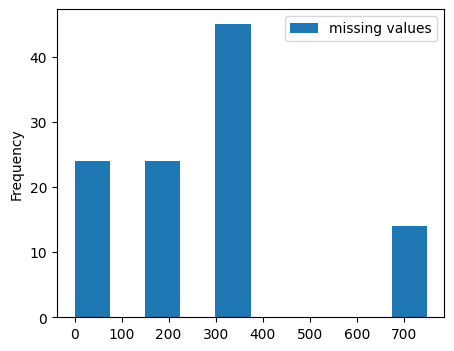

In [8]:
nan_df.plot.hist(figsize=(5, 4))

In [9]:
# Removing columns with more than 400 missing values

dfy = complex_df.drop(
    complex_df.columns[
        complex_df.apply(
            lambda col: col.isnull().sum() >= 400)], axis=1)

In [ ]:
nan_rows = pd.DataFrame(dfy.isnull().sum(axis=1)
                        ).reset_index().rename(columns = {0: 'missing values'})                                                   

In [11]:
nan_rows = pd.merge(pd.DataFrame(basic_df['name']).reset_index(), nan_rows).drop(columns = 'index')

<Axes: ylabel='Frequency'>

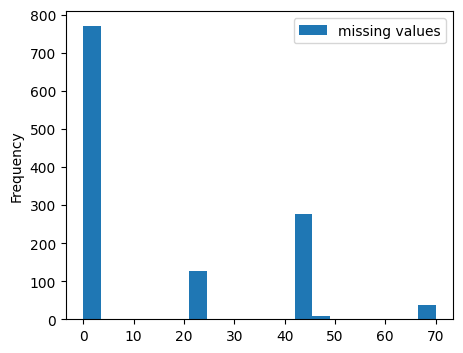

In [12]:
nan_rows.plot.hist(bins = 20, figsize=(5, 4))

In [13]:
# Merging basic and complex data

basic_df = basic_df.reset_index()

complex_df = dfy.dropna().reset_index()

all_df = pd.merge(basic_df, complex_df).drop(columns = 
                                   ['index', 'version', 
                                    'uploader', 'status', 

                                    'format'])
# Renaming columns for uniformity
data_main = all_df.rename(columns =
                          {'did': 'data_id',
                        'name': 'data_name'})

In [14]:
data_main.head()

,data_id,data_name,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,...,RandomTreeDepth2AUC,RandomTreeDepth2ErrRate,RandomTreeDepth2Kappa,RandomTreeDepth3AUC,RandomTreeDepth3ErrRate,RandomTreeDepth3Kappa,StdvNominalAttDistinctValues,kNN1NAUC,kNN1NErrRate,kNN1NKappa
0,2,anneal,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,...,0.929700,0.080178,0.795325,0.929700,0.080178,0.795325,1.557606,0.872195,0.063474,0.826110
1,4,labor,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,...,0.750071,0.298246,0.337662,0.750071,0.298246,0.337662,0.527046,0.767568,0.210526,0.558140
2,5,arrhythmia,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,...,0.621706,0.506637,0.232967,0.621706,0.506637,0.232967,1.334197,0.598570,0.464602,0.212779
3,6,letter,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,...,0.908014,0.176900,0.816017,0.908014,0.176900,0.816017,0.000000,0.973102,0.057850,0.939834
4,9,autos,67.0,22.0,3.0,6.0,26.0,205.0,46.0,59.0,...,0.842526,0.268293,0.651436,0.842526,0.268293,0.651436,5.796551,0.825862,0.258537,0.666329


### Query 3: Extracting tasks meta features

In [15]:
# 🚀 Extracting tasks performed on datasets from OpenML (WITH CACHING!)

def cached_tasks_fetch(dataset_ids):
    """Cached version of tasks extraction"""
    print("🎯 Fetching all tasks from OpenML...")
    tasks_df = openml.tasks.list_tasks(output_format="dataframe")
    
    print(f"📊 Filtering for {len(dataset_ids)} datasets...")
    tasks = tasks_df[tasks_df['did'].isin(dataset_ids)]
    tasks = tasks.sort_values('did')
    tasks.rename(columns = {'did': 'data_id'}, inplace = True)
    
    print(f"✅ Found {len(tasks)} tasks for your datasets")
    return tasks

# Use cached version
tasks = get_cached_data(
    f"tasks_{len(all_df)}_datasets",
    cached_tasks_fetch,
    all_df['did'].tolist()
)

# Grouping the tasks into chunks for the evaluations extraction process
tid = tasks.tid.to_list()
chunks = [tid[x:x+20] for x in range(0, len(tid), 20)]
print(f"🔄 Created {len(chunks)} task chunks for evaluation processing")

📋 Loading from cache: tasks_770_datasets (age: 9.6h)
🔄 Created 834 task chunks for evaluation processing


In [16]:
tasks.head()

,tid,ttid,data_id,name,task_type,status,estimation_procedure,evaluation_measures,source_data,target_feature,...,NumberOfNumericFeatures,NumberOfSymbolicFeatures,number_samples,cost_matrix,source_data_labeled,target_feature_event,target_feature_left,target_feature_right,quality_measure,target_value
0,2,TaskType.SUPERVISED_CLASSIFICATION,2,anneal,Supervised Classification,active,10-fold Crossvalidation,predictive_accuracy,2,class,...,6.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39212,317617,TaskType.CLUSTERING,2,anneal,Clustering,active,50 times Clustering,NaN,2,NaN,...,6.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45844,360136,TaskType.LEARNING_CURVE,2,anneal,Learning Curve,active,10-fold Learning Curve,NaN,2,class,...,6.0,33.0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26497,233217,TaskType.CLUSTERING,2,anneal,Clustering,active,50 times Clustering,NaN,2,NaN,...,6.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18794,189359,TaskType.LEARNING_CURVE,2,anneal,Learning Curve,active,10-fold Learning Curve,NaN,2,class,...,6.0,33.0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Query 4: Extracting evaluations meta features

In [17]:
# 🚀 Extracting tasks evaluations (WITH HEAVY CACHING!)

def cached_evaluations_fetch(chunks):
    """
    Cached version of evaluations extraction - HUGE time saver!
    This function can take 30+ minutes without caching
    """
    print(f"🎯 Processing {len(chunks)} task chunks for evaluations...")
    
    evals = []
    
    try:
        print("🔄 Attempting full extraction (1000 chunks, 10000 size)")
        for i in range(min(1000, len(chunks))):
            if i % 10 == 0:  # Progress every 10 chunks
                print(f"📈 Progress: {i}/{min(1000, len(chunks))} chunks")
            
            chunk_eval = evaluations.list_evaluations(
                tasks=chunks[i],
                function="predictive_accuracy", 
                size=10000, 
                output_format="dataframe"
            )
            evals.append(chunk_eval)
            
    except Exception as e:
        print(f"⚠️ Full extraction failed: {e}")
        print("🔄 Falling back to smaller extraction (100 chunks, 1000 size)")
        
        evals = []  # Reset
        for i in range(min(100, len(chunks))):
            if i % 5 == 0:  # Progress every 5 chunks
                print(f"📈 Fallback progress: {i}/{min(100, len(chunks))} chunks")
                
            chunk_eval = evaluations.list_evaluations(
                tasks=chunks[i],
                function="predictive_accuracy", 
                size=1000, 
                output_format="dataframe"
            )
            evals.append(chunk_eval)
    
    result = pd.concat(evals, ignore_index=True)
    print(f"✅ Extracted {len(result)} evaluation records")
    return result

# Use caching for this expensive operation!
evaluations = get_cached_data(
    f"evaluations_{len(chunks)}_chunks",
    cached_evaluations_fetch,
    chunks
)

print(f"📊 Final evaluations dataset: {evaluations.shape} (rows, columns)")

📋 Loading from cache: evaluations_834_chunks (age: 9.3h)
📊 Final evaluations dataset: (1246719, 14) (rows, columns)


In [18]:
evaluations = evaluations.reset_index().drop('index', axis = 1)

In [19]:
ev = pd.DataFrame(evaluations.flow_name.value_counts().head(30)).reset_index()

In [20]:
evaluations

,run_id,task_id,setup_id,flow_id,flow_name,data_id,data_name,function,upload_time,uploader,uploader_name,value,values,array_data
0,110,2,17,76,weka.Bagging_REPTree(1),2,anneal,predictive_accuracy,2014-04-07 00:24:49,1,Jan van Rijn,0.935412,None,None
1,116,2,4,59,weka.JRip(1),2,anneal,predictive_accuracy,2014-04-07 00:27:44,1,Jan van Rijn,0.951002,None,None
2,321,2,9,64,weka.RandomTree(1),2,anneal,predictive_accuracy,2014-04-07 03:47:18,1,Jan van Rijn,0.925390,None,None
3,323,2,10,65,weka.RandomForest(1),2,anneal,predictive_accuracy,2014-04-07 03:48:15,1,Jan van Rijn,0.940980,None,None
4,419,2,3,58,weka.NaiveBayes(1),2,anneal,predictive_accuracy,2014-04-07 04:50:12,1,Jan van Rijn,0.746102,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246714,10437732,167120,8260873,17374,sklearn.model_selection._search.RandomizedSear...,23517,numerai28.6,predictive_accuracy,2020-02-10 17:09:52,10468,Nicolas Hug,0.519269,None,None
1246715,10418813,167120,8255452,17373,sklearn.model_selection._search_successive_hal...,23517,numerai28.6,predictive_accuracy,2019-11-25 20:05:54,10580,Thomas Fan,0.518719,None,None
1246716,10418881,167120,8255503,17373,sklearn.model_selection._search_successive_hal...,23517,numerai28.6,predictive_accuracy,2019-11-29 13:56:11,10580,Thomas Fan,0.513486,None,None
1246717,10418926,167120,8255505,17373,sklearn.model_selection._search_successive_hal...,23517,numerai28.6,predictive_accuracy,2019-12-02 02:16:04,10580,Thomas Fan,0.513870,None,None


In [21]:
ev.rename(columns = {'index': 'pipelines'}, inplace = True)

-----

# <font color='#E8800A'>Building the Meta Database</font> <a class="anchor" id="third-bullet"></a>
  [Back to META LEARNING](#toc)

In [22]:
# Mapping models from the flows

random_forest = evaluations.loc[evaluations['flow_name'].str.contains('RandomForest') | 
                                evaluations['flow_name'].str.contains('randomforest') |
                                evaluations['flow_name'].str.contains('randomForest') |
                                evaluations['flow_name'].str.contains('ranger')]
random_forest['model'] = 'RandomForest'


SVM_ = evaluations.loc[evaluations['flow_name'].str.contains('SVM') | 
                evaluations['flow_name'].str.contains('svm') | 
                evaluations['flow_name'].str.contains('SVC') | 
                evaluations['flow_name'].str.contains('svc')]
SVM_['model'] = 'SVM'

XGBOOST_ = evaluations.loc[evaluations['flow_name'].str.contains('xgboost')]
XGBOOST_['model'] = 'XGBOOST'

GradientBoosting_ = evaluations.loc[evaluations['flow_name'].str.contains('GradientBoosting')]
GradientBoosting_['model'] = 'GradientBoosting'

DecisionTrees_ = evaluations.loc[evaluations['flow_name'].str.contains('DecisionTree') | 
                                evaluations['flow_name'].str.contains('rpart')]
DecisionTrees_['model'] = 'DecisionTree'

glmnet_ = evaluations.loc[evaluations['flow_name'].str.contains('glmnet')]
glmnet_['model'] = 'glmnet'

NaiveBayes_ = evaluations.loc[evaluations['flow_name'].str.contains('NaiveBayes')]
NaiveBayes_['model'] = 'NaiveBayes'

evals_models = pd.concat([glmnet_, DecisionTrees_, GradientBoosting_, 
                          XGBOOST_, SVM_, random_forest, NaiveBayes_])

In [23]:
tasks_frequency_per_model = pd.DataFrame(
    evals_models['model'].value_counts()
                                         ).reset_index().rename(
                                             columns = {'model': 'Model',
                                                        'count': 'Number of Tasks'}
                                                                       )

<Axes: ylabel='Model'>

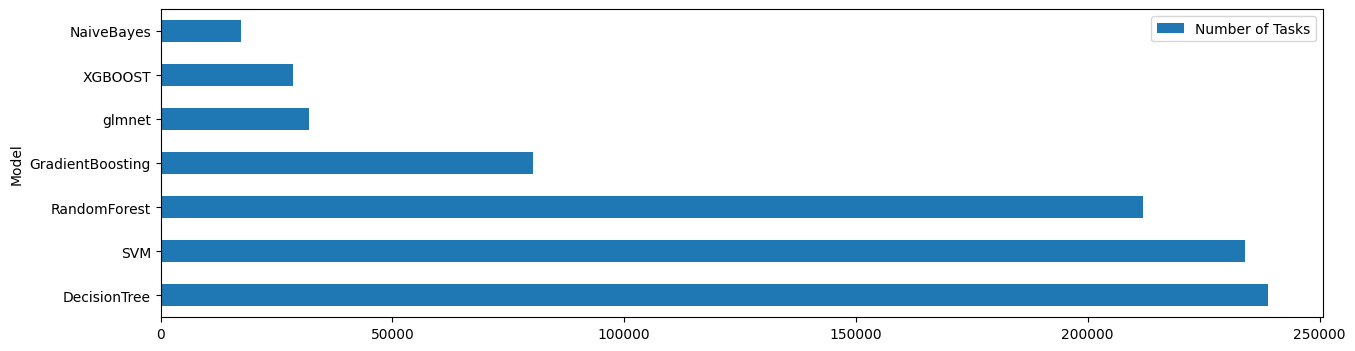

In [24]:
tasks_frequency_per_model.set_index('Model').plot.barh(figsize = (15,4))

In [25]:
# Finding the best models for each dataset

datasets_ids = list(evals_models['data_id'].unique())

maxis = []

for i in datasets_ids:
    subdfs = evals_models[evals_models['data_id'] == i]
    max_subdfs = subdfs[subdfs['value'] == subdfs['value'].max()]
    maxis.append(max_subdfs)
    
maximu = pd.concat(maxis)

maximu = maximu.drop_duplicates(subset = ['data_id', 'flow_name']
                                ).reset_index().drop(columns = 'index')

<Axes: ylabel='Model'>

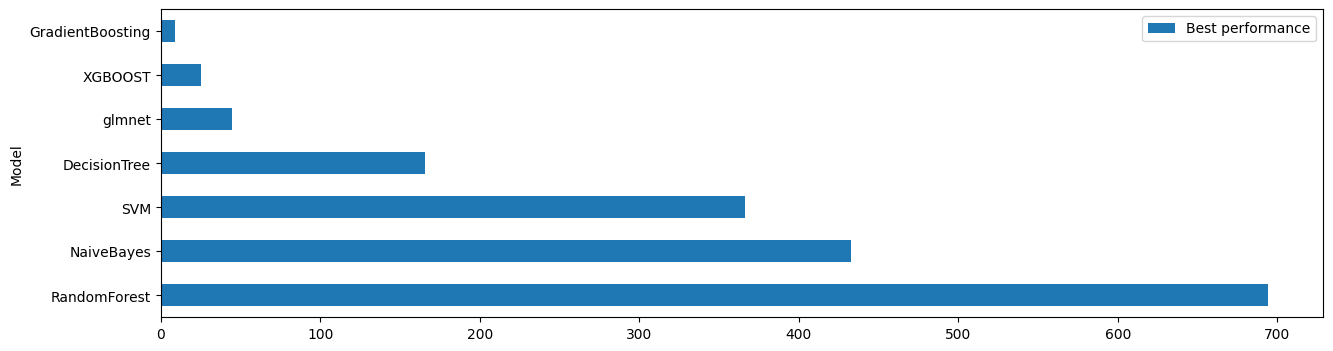

In [26]:
best_models = pd.DataFrame(maximu.model.value_counts()
                           ).reset_index().rename(columns = {'model': 'Model',
                                                             'count': 'Best performance'}
                                                                       )
best_models.set_index('Model').plot.barh(figsize = (15,4))

<Axes: ylabel='Model'>

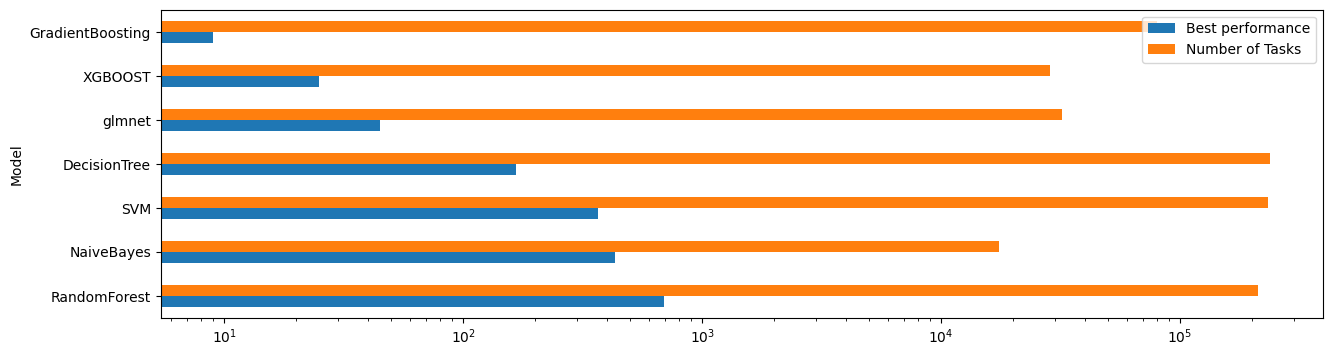

In [27]:
pd.merge(best_models, tasks_frequency_per_model).set_index('Model').plot.barh(
    figsize = (15,4), logx = True)

In [28]:
pd.merge(best_models, tasks_frequency_per_model)

,Model,Best performance,Number of Tasks
0,RandomForest,694,212013
1,NaiveBayes,433,17423
2,SVM,366,233902
3,DecisionTree,166,238841
4,glmnet,45,31980
5,XGBOOST,25,28504
6,GradientBoosting,9,80344


In [29]:
# Taking the most voted model - ensembling method

data_id = list(maximu.data_id.unique())

j = []
for i in data_id:
    h = maximu[maximu['data_id'] == i].model.value_counts().head(1).reset_index().iloc[0][0]
    j.append(h)
    
    
ensembled = pd.DataFrame(data_id, j).reset_index().rename(columns = 
                                                          {'index': 'Model', 
                                                           0: 'data_id'})

In [30]:
ensembled_best = pd.DataFrame(ensembled.Model.value_counts()
                              ).reset_index().rename(columns = {'count': 'Frequency'}
                                                                       )

<Axes: ylabel='Model'>

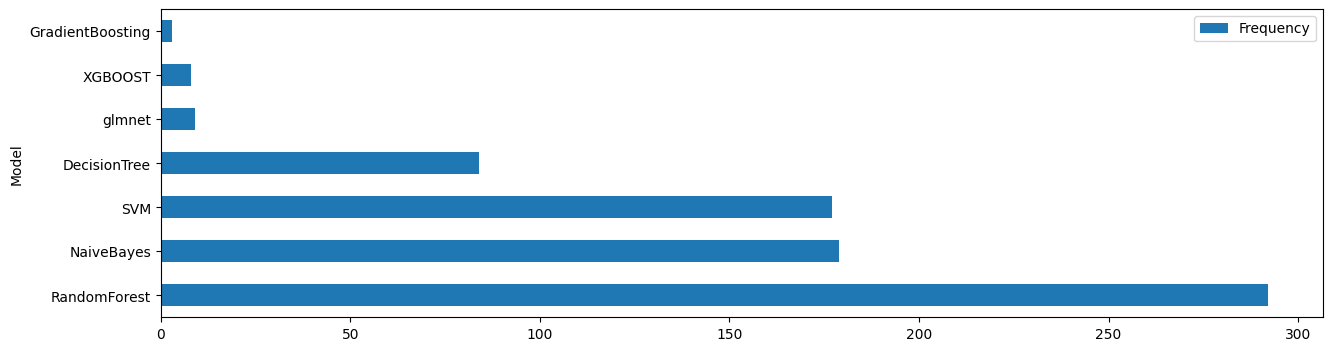

In [31]:
ensembled_best.set_index('Model').plot.barh(figsize = (15,4))

In [32]:
ensembled_ = pd.merge(maximu.drop_duplicates('data_id').drop(
    columns = 'model'), ensembled)

In [33]:
# Merging the main metadata dataset with the ensembled best performing models dataset

finale = pd.merge(data_main, ensembled_)#.drop(columns = 'level_0')

In [34]:
# Renaming and filtering columns 

finale.rename(columns = {'J48.00001.ErrRate': 'J48_00001_ErrRate',
                       'J48.00001.Kappa': 'J48_00001_Kappa',
                       'J48.0001.ErrRate': 'J48_0001_ErrRate',
                       'J48.0001.Kappa': 'J48_0001_Kappa',
                       'J48.001.ErrRate': 'J48_001_ErrRate',
                       'J48.001.Kappa': 'J48_001_Kappa'
                      }, inplace = True)


finale = finale[['data_id', 'data_name','NumberOfInstances', 'NumberOfFeatures', 'NumberOfSymbolicFeatures', 'NumberOfNumericFeatures', \
'PercentageOfNumericFeatures','PercentageOfSymbolicFeatures', 'NumberOfMissingValues', 'NumberOfInstancesWithMissingValues', \
'PercentageOfMissingValues','PercentageOfInstancesWithMissingValues', 'MaxNominalAttDistinctValues', 'ClassEntropy', 'Dimensionality', \
'MajorityClassPercentage', 'MinorityClassPercentage', 'MajorityClassSize', 'MinorityClassSize', 'NumberOfClasses', \
'MaxKurtosisOfNumericAtts', 'MinKurtosisOfNumericAtts', 'MeanKurtosisOfNumericAtts', 'Quartile1KurtosisOfNumericAtts', \
'Quartile2KurtosisOfNumericAtts', 'Quartile3KurtosisOfNumericAtts', 'MaxSkewnessOfNumericAtts', 'MinSkewnessOfNumericAtts', \
'MeanSkewnessOfNumericAtts', 'Quartile1SkewnessOfNumericAtts', 'Quartile2SkewnessOfNumericAtts', 'Quartile3SkewnessOfNumericAtts', \
'MaxStdDevOfNumericAtts', 'MinStdDevOfNumericAtts', 'MeanStdDevOfNumericAtts', 'Quartile1StdDevOfNumericAtts', \
'Quartile2StdDevOfNumericAtts', 'Quartile3StdDevOfNumericAtts', 'NumberOfBinaryFeatures', 'PercentageOfBinaryFeatures', \
'Quartile1MeansOfNumericAtts', 'Quartile2MeansOfNumericAtts', 'Quartile3MeansOfNumericAtts', 'J48_00001_ErrRate', 'J48_00001_Kappa', \
'J48_0001_ErrRate', 'J48_0001_Kappa', 'J48_001_ErrRate', 'J48_001_Kappa', 'REPTreeDepth1ErrRate', 'REPTreeDepth1Kappa', \
'REPTreeDepth2ErrRate', 'REPTreeDepth2Kappa', 'REPTreeDepth3ErrRate', 'REPTreeDepth3Kappa', 'RandomTreeDepth1ErrRate', \
'RandomTreeDepth1Kappa', 'RandomTreeDepth2ErrRate', 'RandomTreeDepth2Kappa', 'RandomTreeDepth3ErrRate', 'RandomTreeDepth3Kappa', \
'kNN1NErrRate', 'kNN1NKappa', 'NaiveBayesErrRate', 'NaiveBayesKappa', 'MaxMeansOfNumericAtts', 'MinMeansOfNumericAtts', 'MeanMeansOfNumericAtts', 'Model'
]]

In [35]:
# The final Meta DB

finale

,data_id,data_name,NumberOfInstances,NumberOfFeatures,NumberOfSymbolicFeatures,NumberOfNumericFeatures,PercentageOfNumericFeatures,PercentageOfSymbolicFeatures,NumberOfMissingValues,NumberOfInstancesWithMissingValues,...,RandomTreeDepth3ErrRate,RandomTreeDepth3Kappa,kNN1NErrRate,kNN1NKappa,NaiveBayesErrRate,NaiveBayesKappa,MaxMeansOfNumericAtts,MinMeansOfNumericAtts,MeanMeansOfNumericAtts,Model
0,2,anneal,898.0,39.0,33.0,6.0,15.384615,84.615385,22175.0,898.0,...,0.080178,0.795325,0.063474,0.826110,0.246102,0.556959,1263.094655,1.198549,348.504268,RandomForest
1,4,labor,57.0,17.0,9.0,8.0,47.058824,52.941176,326.0,56.0,...,0.298246,0.337662,0.210526,0.558140,0.070175,0.845946,38.039216,2.160714,9.412291,SVM
2,5,arrhythmia,452.0,280.0,74.0,206.0,73.571429,26.428571,408.0,384.0,...,0.506637,0.232967,0.464602,0.212779,0.396018,0.406572,367.207965,-23.499115,14.348605,RandomForest
3,6,letter,20000.0,17.0,1.0,16.0,94.117647,5.882353,0.0,0.0,...,0.176900,0.816017,0.057850,0.939834,0.360250,0.625325,8.338850,3.046100,5.925466,SVM
4,9,autos,205.0,26.0,11.0,15.0,57.692308,42.307692,59.0,46.0,...,0.268293,0.651436,0.258537,0.666329,0.419512,0.462467,13207.129353,3.255423,1447.091008,RandomForest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,6332,cylinder-bands,540.0,40.0,22.0,18.0,45.000000,55.000000,999.0,263.0,...,0.411111,0.146300,0.322222,0.321138,0.329630,0.324393,37287.531481,0.038144,2198.883738,GradientBoosting
748,23380,cjs,2796.0,35.0,3.0,32.0,91.428571,8.571429,68100.0,2795.0,...,0.170243,0.791463,0.808298,0.027478,0.247854,0.692601,9.333870,0.300000,2.813529,RandomForest
749,23381,dresses-sales,500.0,13.0,12.0,1.0,7.692308,92.307692,835.0,401.0,...,0.408000,0.127011,0.442000,0.077629,0.396000,0.158450,3.528600,3.528600,3.528600,SVM
750,23512,higgs,98050.0,29.0,1.0,28.0,96.551724,3.448276,9.0,1.0,...,0.386996,0.228399,0.452585,0.089242,0.401346,0.173431,1.050129,-0.007896,0.607370,RandomForest


----------------

# <font color='#E8800A'>Exploratory Data Analysis and Preprocessing</font> <a class="anchor" id="forth-bullet"></a>
  [Back to META LEARNING](#toc)

In [37]:
finale.describe()

,data_id,NumberOfInstances,NumberOfFeatures,NumberOfSymbolicFeatures,NumberOfNumericFeatures,PercentageOfNumericFeatures,PercentageOfSymbolicFeatures,NumberOfMissingValues,NumberOfInstancesWithMissingValues,PercentageOfMissingValues,...,RandomTreeDepth2Kappa,RandomTreeDepth3ErrRate,RandomTreeDepth3Kappa,kNN1NErrRate,kNN1NKappa,NaiveBayesErrRate,NaiveBayesKappa,MaxMeansOfNumericAtts,MinMeansOfNumericAtts,MeanMeansOfNumericAtts
count,752.000000,7.520000e+02,752.000000,752.000000,752.000000,752.000000,752.000000,7.520000e+02,752.000000,752.000000,...,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,7.520000e+02,7.520000e+02,7.520000e+02
mean,1056.224734,1.444140e+05,1608.731383,4.664894,1604.066489,76.343255,23.656745,3.247354e+04,280.941489,1.115229,...,0.461857,0.258227,0.463923,0.251645,0.475334,0.257192,0.474734,2.566946e+16,-2.108319e+07,2.333587e+15
std,1735.443187,3.811184e+05,6216.514317,8.924715,6217.437885,27.324705,27.324705,5.061264e+05,3207.635982,6.656981,...,0.290278,0.181732,0.289360,0.189846,0.313335,0.172229,0.276616,4.974178e+17,5.745350e+08,4.521980e+16
min,2.000000,2.300000e+01,2.000000,1.000000,1.000000,2.857143,0.001630,0.000000e+00,0.000000,0.000000,...,-0.312281,0.000000,-0.312281,0.000000,-0.320000,0.000000,-0.243902,-1.263297e-04,-1.575509e+10,-1.372188e+08
25%,728.750000,1.947500e+02,9.000000,1.000000,5.000000,63.516746,2.614710,0.000000e+00,0.000000,0.000000,...,0.224200,0.114289,0.229087,0.091318,0.200433,0.118683,0.272415,2.999568e+00,0.000000e+00,6.561914e-01
50%,927.500000,5.440000e+02,17.000000,1.000000,10.000000,88.888889,11.111111,0.000000e+00,0.000000,0.000000,...,0.459912,0.220018,0.459912,0.214453,0.467536,0.231940,0.449633,8.478921e+01,5.228862e-01,3.616076e+01
75%,1167.500000,7.400000e+03,49.250000,3.000000,44.000000,97.385290,36.483254,0.000000e+00,0.000000,0.000000,...,0.700458,0.368198,0.701134,0.391498,0.741179,0.368500,0.692740,2.331920e+03,3.696344e+00,3.982386e+02
max,23517.000000,4.898431e+06,61360.000000,74.000000,61359.000000,99.998370,97.142857,8.024152e+06,50000.000000,69.589209,...,1.000000,0.992308,1.000000,0.976923,1.000000,0.940979,1.000000,9.655787e+18,1.821279e+07,8.777988e+17


------------------------------

# <font color='#E8800A'>Metadata Extraction Algorithm - The extractor</font> <a class="anchor" id="fifth-bullet"></a>
  [Back to META LEARNING](#toc)

In [38]:
# Counts how many binary columns exist on the dataset

def binary_column(dataset):    
    binaries = []

    for i in range(len(dataset.columns)):
        column = list(dataset.columns)[i]

        if len(dataset[column].unique()) == 2:
            binaries.append(column)

    return binaries

In [39]:
# Calculates landmarking metadata using sklearn (replaces Weka functionality)

def landmarking_sklearn(dataset_path, classifier_type, **params):
    """
    Sklearn-based landmarking to replace Weka functionality.
    Returns error rate and Cohen's Kappa using 10-fold cross validation.
    """
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import cohen_kappa_score, make_scorer
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    import pandas as pd
    
    # Load dataset
    data = pd.read_csv(dataset_path)
    
    # Assume last column is target (following original Weka convention)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    
    # Handle non-numeric data
    from sklearn.preprocessing import LabelEncoder
    le_X = LabelEncoder()
    le_y = LabelEncoder()
    
    # Encode categorical features
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = le_X.fit_transform(X[col].astype(str))
    
    # Encode target
    if y.dtype == 'object':
        y = le_y.fit_transform(y)
    
    # Select classifier based on type
    if classifier_type == "J48":  # Decision Tree equivalent
        classifier = DecisionTreeClassifier(
            random_state=1, 
            min_samples_split=params.get('min_samples_split', 2),
            max_depth=params.get('max_depth', None)
        )
    elif classifier_type == "REPTree":  # Another Decision Tree variant
        classifier = DecisionTreeClassifier(
            random_state=1,
            max_depth=params.get('max_depth', 3),
            min_samples_leaf=params.get('min_samples_leaf', 2)
        )
    elif classifier_type == "RandomTree":  # Extra Tree equivalent
        classifier = ExtraTreesClassifier(
            n_estimators=1, 
            random_state=1,
            max_depth=params.get('max_depth', None)
        )
    elif classifier_type == "KNN":
        classifier = KNeighborsClassifier(n_neighbors=params.get('k', 1))
    elif classifier_type == "NaiveBayes":
        classifier = GaussianNB()
    else:
        classifier = DecisionTreeClassifier(random_state=1)
    
    # 10-fold cross validation for accuracy
    accuracy_scores = cross_val_score(classifier, X, y, cv=10, scoring='accuracy')
    error_rate = 1 - accuracy_scores.mean()
    
    # Calculate Kappa using cross validation
    def kappa_scorer(estimator, X, y):
        y_pred = estimator.predict(X)
        return cohen_kappa_score(y, y_pred)
    
    kappa_scores = cross_val_score(classifier, X, y, cv=10, scoring=make_scorer(kappa_scorer))
    kappa = kappa_scores.mean()
    
    return None, error_rate, kappa

In [40]:
# The main algorithm

def feature_extractor(data, target):
    
    dataset = pd.read_csv(data)
    
    #Placing target class as the last column
    #end_col = [target] 
    #other_cols = [col for col in dataset.columns if col not in end_col]
    #dataset = dataset[other_cols + end_col]
    
    cols = (dataset.columns[dataset.dtypes.eq('int64')]).to_list()
    dataset[cols] = dataset[cols].astype('float')
    
    dataset[dataset.select_dtypes(['int64']).columns] = dataset.select_dtypes([
    'int64']).apply(lambda x: x.astype('float'))
    
    NumberOfInstances, NumberOfFeatures = dataset.shape
    NumberOfNumericFeatures, NumberOfSymbolicFeatures = len(dataset.select_dtypes(
        ['float64']).columns), len(dataset.select_dtypes(['object']).columns)
    PercentageOfNumericFeatures = (NumberOfNumericFeatures / NumberOfFeatures) * 100
    PercentageOfSymbolicFeatures = (NumberOfSymbolicFeatures / NumberOfFeatures) * 100
    
    NumberOfMissingValues = dataset.isna().sum().sum()
    NumberOfInstancesWithMissingValues = (dataset.isna().sum() > 1).sum()
    PercentageOfMissingValues = (NumberOfMissingValues / (NumberOfInstances * NumberOfFeatures)) * 100
    PercentageOfInstancesWithMissingValues = (NumberOfInstancesWithMissingValues / NumberOfInstances) * 100
    
    cat_cols = dataset.select_dtypes(include=object).columns.tolist()
    if cat_cols:  # Check if there are any categorical columns
        value_counts_series = dataset[cat_cols].melt(var_name='column', value_name='value').value_counts()
        m = pd.DataFrame({'counts': value_counts_series}).sort_values(by=['counts'])
        MaxNominalAttDistinctValues = m.counts.max()
    else:
        MaxNominalAttDistinctValues = 0  # No categorical columns
    
    # Safe entropy calculation
    try:
        p_data = dataset[target].value_counts(normalize=True)
        ClassEntropy = scipy.stats.entropy(p_data) if len(p_data) > 0 else 0
        ClassEntropy = 0 if np.isnan(ClassEntropy) or np.isinf(ClassEntropy) else ClassEntropy
    except:
        ClassEntropy = 0
    
    Dimensionality =  NumberOfFeatures / NumberOfInstances
    
    MajorityClassPercentage = (dataset[target].value_counts().max() / dataset[target].value_counts().sum()) * 100
    MinorityClassPercentage = (dataset[target].value_counts().min() / dataset[target].value_counts().sum()) * 100
    MajorityClassSize = dataset[target].value_counts().max()
    MinorityClassSize = dataset[target].value_counts().min()
    NumberOfClasses = len(dataset[target].unique())
    
    # Only calculate statistical measures on numeric columns
    numeric_data = dataset.select_dtypes(include=[np.number])
    
    # Handle case where there are no numeric columns
    if len(numeric_data.columns) == 0:
        MaxKurtosisOfNumericAtts = 0
        MinKurtosisOfNumericAtts = 0
        MeanKurtosisOfNumericAtts = 0
        Quartile1KurtosisOfNumericAtts = 0
        Quartile2KurtosisOfNumericAtts = 0
        Quartile3KurtosisOfNumericAtts = 0
        
        MaxMeansOfNumericAtts = 0
        MinMeansOfNumericAtts = 0
        MeanMeansOfNumericAtts = 0
        
        MaxSkewnessOfNumericAtts = 0
        MinSkewnessOfNumericAtts = 0
        MeanSkewnessOfNumericAtts = 0
        Quartile1SkewnessOfNumericAtts = 0
        Quartile2SkewnessOfNumericAtts = 0
        Quartile3SkewnessOfNumericAtts = 0
        
        MaxStdDevOfNumericAtts = 0
        MinStdDevOfNumericAtts = 0
        MeanStdDevOfNumericAtts = 0
        Quartile1StdDevOfNumericAtts = 0
        Quartile2StdDevOfNumericAtts = 0
        Quartile3StdDevOfNumericAtts = 0
    else:
        # Safe calculation with NaN handling
        kurtosis_vals = numeric_data.kurtosis().fillna(0)
        MaxKurtosisOfNumericAtts = kurtosis_vals.max() if not kurtosis_vals.empty else 0
        MinKurtosisOfNumericAtts = kurtosis_vals.min() if not kurtosis_vals.empty else 0
        MeanKurtosisOfNumericAtts = kurtosis_vals.mean() if not kurtosis_vals.empty else 0
        
        kurtosis_quartiles = kurtosis_vals.quantile([0.25, 0.5, 0.75])
        Quartile1KurtosisOfNumericAtts = kurtosis_quartiles.iloc[0] if len(kurtosis_quartiles) > 0 else 0
        Quartile2KurtosisOfNumericAtts = kurtosis_quartiles.iloc[1] if len(kurtosis_quartiles) > 1 else 0
        Quartile3KurtosisOfNumericAtts = kurtosis_quartiles.iloc[2] if len(kurtosis_quartiles) > 2 else 0
        
        means_vals = numeric_data.mean().fillna(0)
        MaxMeansOfNumericAtts = means_vals.max() if not means_vals.empty else 0
        MinMeansOfNumericAtts = means_vals.min() if not means_vals.empty else 0
        MeanMeansOfNumericAtts = means_vals.mean() if not means_vals.empty else 0
        
        skew_vals = numeric_data.skew().fillna(0)
        MaxSkewnessOfNumericAtts = skew_vals.max() if not skew_vals.empty else 0
        MinSkewnessOfNumericAtts = skew_vals.min() if not skew_vals.empty else 0
        MeanSkewnessOfNumericAtts = skew_vals.mean() if not skew_vals.empty else 0
        
        skew_quartiles = skew_vals.quantile([0.25, 0.5, 0.75])
        Quartile1SkewnessOfNumericAtts = skew_quartiles.iloc[0] if len(skew_quartiles) > 0 else 0
        Quartile2SkewnessOfNumericAtts = skew_quartiles.iloc[1] if len(skew_quartiles) > 1 else 0
        Quartile3SkewnessOfNumericAtts = skew_quartiles.iloc[2] if len(skew_quartiles) > 2 else 0
        
        std_vals = numeric_data.std().fillna(0)
        MaxStdDevOfNumericAtts = std_vals.max() if not std_vals.empty else 0
        MinStdDevOfNumericAtts = std_vals.min() if not std_vals.empty else 0
        MeanStdDevOfNumericAtts = std_vals.mean() if not std_vals.empty else 0
        
        std_quartiles = std_vals.quantile([0.25, 0.5, 0.75])
        Quartile1StdDevOfNumericAtts = std_quartiles.iloc[0] if len(std_quartiles) > 0 else 0
        Quartile2StdDevOfNumericAtts = std_quartiles.iloc[1] if len(std_quartiles) > 1 else 0
        Quartile3StdDevOfNumericAtts = std_quartiles.iloc[2] if len(std_quartiles) > 2 else 0
    
    NumberOfBinaryFeatures = len(binary_column(dataset))
    PercentageOfBinaryFeatures = (NumberOfBinaryFeatures / NumberOfFeatures) * 100
    
    # Calculate mean quartiles safely
    if len(numeric_data.columns) > 0:
        means_quartiles = means_vals.quantile([0.25, 0.5, 0.75])
        Quartile1MeansOfNumericAtts = means_quartiles.iloc[0] if len(means_quartiles) > 0 else 0
        Quartile2MeansOfNumericAtts = means_quartiles.iloc[1] if len(means_quartiles) > 1 else 0
        Quartile3MeansOfNumericAtts = means_quartiles.iloc[2] if len(means_quartiles) > 2 else 0
    else:
        Quartile1MeansOfNumericAtts = 0
        Quartile2MeansOfNumericAtts = 0
        Quartile3MeansOfNumericAtts = 0
    
    
    # Landmarking values using sklearn (replaces Weka functionality)
    # J48 equivalent - Decision Trees with different complexity parameters
    
    J48_00001_evl, J48_00001_ErrRate, J48_00001_Kappa = landmarking_sklearn(
        data, "J48", min_samples_split=20, max_depth=10)
    
    J48_0001_evl, J48_0001_ErrRate, J48_0001_Kappa = landmarking_sklearn(
        data, "J48", min_samples_split=15, max_depth=15)
    
    J48_001_evl, J48_001_ErrRate, J48_001_Kappa = landmarking_sklearn(
        data, "J48", min_samples_split=10, max_depth=20)
    
    
    # REPTree equivalent - Decision Trees with depth limits
    
    REPTreeDepth1_evl, REPTreeDepth1ErrRate, REPTreeDepth1Kappa = landmarking_sklearn(
        data, "REPTree", max_depth=1)
    
    REPTreeDepth2_evl, REPTreeDepth2ErrRate, REPTreeDepth2Kappa = landmarking_sklearn(
        data, "REPTree", max_depth=2)
    
    REPTreeDepth3_evl, REPTreeDepth3ErrRate, REPTreeDepth3Kappa = landmarking_sklearn(
        data, "REPTree", max_depth=3)
    
    
    # RandomTree equivalent - Extra Trees with depth limits
    
    RandomTreeDepth1_evl, RandomTreeDepth1ErrRate, RandomTreeDepth1Kappa = landmarking_sklearn(
        data, "RandomTree", max_depth=1)
    
    RandomTreeDepth2_evl, RandomTreeDepth2ErrRate, RandomTreeDepth2Kappa = landmarking_sklearn(
        data, "RandomTree", max_depth=2)
    
    RandomTreeDepth3_evl, RandomTreeDepth3ErrRate, RandomTreeDepth3Kappa = landmarking_sklearn(
        data, "RandomTree", max_depth=3)
    
    # KNN equivalent
    
    kNN1N_evl, kNN1NErrRate, kNN1NKappa = landmarking_sklearn(
        data, "KNN", k=1)
    
    NaiveBayes_evl, NaiveBayesErrRate, NaiveBayesKappa = landmarking_sklearn(
        data, "NaiveBayes")
    
    
    mex = NumberOfInstances, NumberOfFeatures, NumberOfSymbolicFeatures, NumberOfNumericFeatures, \
                PercentageOfNumericFeatures,PercentageOfSymbolicFeatures, NumberOfMissingValues, NumberOfInstancesWithMissingValues, \
                PercentageOfMissingValues,PercentageOfInstancesWithMissingValues, MaxNominalAttDistinctValues, ClassEntropy, Dimensionality, \
                MajorityClassPercentage, MinorityClassPercentage, MajorityClassSize, MinorityClassSize, NumberOfClasses, \
                MaxKurtosisOfNumericAtts, MinKurtosisOfNumericAtts, MeanKurtosisOfNumericAtts, Quartile1KurtosisOfNumericAtts, \
                Quartile2KurtosisOfNumericAtts, Quartile3KurtosisOfNumericAtts, MaxSkewnessOfNumericAtts, MinSkewnessOfNumericAtts, \
                MeanSkewnessOfNumericAtts, Quartile1SkewnessOfNumericAtts, Quartile2SkewnessOfNumericAtts, Quartile3SkewnessOfNumericAtts, \
                MaxStdDevOfNumericAtts, MinStdDevOfNumericAtts, MeanStdDevOfNumericAtts, Quartile1StdDevOfNumericAtts, \
                Quartile2StdDevOfNumericAtts, Quartile3StdDevOfNumericAtts, NumberOfBinaryFeatures, PercentageOfBinaryFeatures, \
                Quartile1MeansOfNumericAtts, Quartile2MeansOfNumericAtts, Quartile3MeansOfNumericAtts, J48_00001_ErrRate, J48_00001_Kappa, \
                J48_0001_ErrRate, J48_0001_Kappa, J48_001_ErrRate, J48_001_Kappa, REPTreeDepth1ErrRate, REPTreeDepth1Kappa, \
                REPTreeDepth2ErrRate, REPTreeDepth2Kappa, REPTreeDepth3ErrRate, REPTreeDepth3Kappa, RandomTreeDepth1ErrRate, \
                RandomTreeDepth1Kappa, RandomTreeDepth2ErrRate, RandomTreeDepth2Kappa, RandomTreeDepth3ErrRate, RandomTreeDepth3Kappa, \
                kNN1NErrRate, kNN1NKappa, NaiveBayesErrRate, NaiveBayesKappa, MaxMeansOfNumericAtts, MinMeansOfNumericAtts, MeanMeansOfNumericAtts
    
    # Clean up any remaining NaN or Inf values
    cleaned_mex = []
    for val in mex:
        if np.isnan(val) or np.isinf(val):
            cleaned_mex.append(0.0)  # Replace with 0
        else:
            cleaned_mex.append(float(val))  # Ensure it's a float
    
    return tuple(cleaned_mex)

------------------------------

# <font color='#E8800A'>Predicting a Dataset's Model - The Meta Learner </font> <a class="anchor" id="sixth-bullet"></a>
  [Back to META LEARNING](#toc)

In [41]:
KB_datasets = finale.drop(columns = ['data_id', 'Model']).set_index('data_name')

In [42]:
from scipy.spatial import distance

def meta_learner(extractor):
    dists = []

    for i in range(473):
        Si = tuple(KB_datasets.iloc[i])
        min_S = distance.euclidean(Si, extractor)

        dists.append(min_S)

    min_dist = min(dists)
    
    min_index = dists.index(min_dist)
    
    closest_df = maximu.data_name[min_index]
    
    the_model = ensembled[ensembled['data_id'] == maximu[maximu['data_name'] == closest_df
                                        ]['data_id'].iat[0]]['Model'].iat[0]
    
    return the_model

-------------------------

# <font color='#E8800A'>Optimizing a Dataset's Model - The Optimizer </font> <a class="anchor" id="sixth-bullet"></a>
  [Back to META LEARNING](#toc)
  
  
  
  - Code adapted from: https://towardsdatascience.com/swarm-intelligence-coding-and-visualising-particle-swarm-optimisation-in-python-253e1bd00772 

### 1. Defining the fitness function

In [43]:
def fitness_function(data, target, x1, x2, x3):
    
    test_df = pd.read_csv(data)
    X = test_df.drop(columns = target)
    y = test_df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.25, 
                                                        random_state = x3)
    
    a = MinMaxScaler()

    b = StandardScaler()

    sc = random.choice([a, b])
    #sc = StandardScaler()
    
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    selected_model = meta_learner(feature_extractor(data ,target))
    
    if selected_model == 'RandomForest':
        mod = RandomForestClassifier(max_depth=x1, random_state=x2, 
                                     min_samples_leaf = 6).fit(X_train, y_train)

    
    elif selected_model == 'SVM':
        mod = SVC(cache_size = x1,random_state=x2).fit(X_train, y_train)
        
        
    elif selected_model == 'DecisionTree': 
        mod = DecisionTreeClassifier(max_depth=x1, random_state=x2, 
                                     min_samples_leaf = 6).fit(X_train, y_train)
        
        
    elif selected_model == 'XGBOOST': 
        mod = XGBClassifier(max_depth=x1, seed=x2).fit(X_train, y_train)
        

    if selected_model == 'GradientBoosting':
        mod = GradientBoostingClassifier(max_depth=x1, random_state=x2, 
                                     min_samples_leaf = 6).fit(X_train, y_train)

        
    
    labels_train = mod.predict(X_train)
    labels_test = mod.predict(X_test)
    
    train_acc = round(mod.score(X_train, y_train), 2)
    test_acc = round(mod.score(X_test, y_test), 2)
    
    print("Scaler:", sc, "Model:", selected_model, 
          "Train accuracy:" , train_acc, "Test accuracy:" ,test_acc, "                                                                                                          ")
    
    
    
    return test_acc

### 2. Function to update velocity

In [44]:
def update_velocity(particle, velocity, pbest, gbest, w_min = 0.4, max_ = 0.9, c = 1):
    
    '''Initialize new velocity array'''
    
    num_particle = len(particle)
    new_velocity = np.array([0 for i in range(num_particle)])
    
    
    '''Randomly generate r1, r2 and w from normal distribution'''
    
    r1 = random.uniform(0, max_)
    r2 = random.uniform(0, max_)
    w = random.uniform(w_min, max_)
    c1 = c2 = c
    
    
    '''Calculating new velocity'''
    
    for i in range(num_particle):
        new_velocity[i] = w*velocity[i] + c1*r1*(pbest[i]-particle[i] + c2*r2*(gbest[i] - particle[i]))
        
    
    return abs(np.around(new_velocity))

### 3. Function to update particle position

In [45]:
def update_position(particle, velocity):
    
    # Move particles by adding velocity
    new_particle = particle + velocity
    
    return new_particle

### The main PSO function 

In [46]:
def PSO(data, target, population, dimension, position_min, position_max, generation, fitness_criterion):
    
    '''Initialisation''' 
    
    # i. Population
    particles = [[random.randint(position_min, position_max) for j in range(dimension)] for i in range(population)]
    
    # ii. Particle's best position
    pbest_position = particles
    
    # iii. Particles' best fitness
    pbest_fitness = [fitness_function(data, target,p[0], p[1],p[2]) for p in particles]
    
    # iv. Global best position
    gbest_index = np.argmax(pbest_fitness)
    gbest_position = pbest_position[gbest_index]
    
    # v. Velocity starting from zero 0
    velocity = [[0 for j in range(dimension)] for i in range(population)]
    
    
    
    '''Looping''' 
    
    for t in range(generation):
        # Stop if the average fitness value reached the predefined fitness criterion
        if np.average(pbest_fitness) >= fitness_criterion:
            break
        else:
            for n in range(population):
                # Update the velocity of each particle
                velocity[n] = update_velocity(particles[n], velocity[n], 
                                              pbest_position[n], gbest_position)
                
                # Move particles to the new position
                particles[n] = update_position(particles[n], velocity[n])
                
        # Calculate the fitness value
        pbest_fitness = [fitness_function(data, target,p[0], p[1],p[2]) for p in particles]
        
        # Finding the global position
        gbest_index = np.argmax(pbest_fitness)
        gbest_position = pbest_position[gbest_index]
       
        
    
    '''Printing results'''
    print(                                                     )
    print('------------------------------------------------------')
    print(                                                     )


    print('Global Best Position: ', gbest_position)
    print('Best Fitness Value: ', max(pbest_fitness))
    print('Average Particle Best Fitness Value: ', np.average(pbest_fitness))
    print('Number of Generation: ', t)

In [47]:
PSO(data = 'abalone.csv', 
    target = "Sex",
    population = 10,
       dimension = 3,
       position_min = 1,
       position_max = 5,
       generation = 5,
       fitness_criterion = 99)

Scaler: MinMaxScaler() Model: RandomForest Train accuracy: 0.59 Test accuracy: 0.53                                                                                                           
Scaler: MinMaxScaler() Model: RandomForest Train accuracy: 0.53 Test accuracy: 0.53                                                                                                           
Scaler: StandardScaler() Model: RandomForest Train accuracy: 0.56 Test accuracy: 0.52                                                                                                           
Scaler: StandardScaler() Model: RandomForest Train accuracy: 0.54 Test accuracy: 0.53                                                                                                           
Scaler: MinMaxScaler() Model: RandomForest Train accuracy: 0.57 Test accuracy: 0.52                                                                                                           
Scaler: StandardScaler() Model: RandomFor

In [49]:
pd.read_csv('abalone.csv')

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [ ]:
PSO(data = 'semeion2.csv', 
    target = "Class",
    population = 10,
       dimension = 3,
       position_min = 1,
       position_max = 20,
       generation = 10,
       fitness_criterion = 90)

In [ ]:
PSO(data = 'yeast.csv', 
    target = "'class_protein_localization'",
    population = 50,
       dimension = 3,
       position_min = 1,
       position_max = 20,
       generation = 10,
       fitness_criterion = 99)

In [ ]:
PSO(data = 'madelon2.csv', 
    target = "Class",
    population = 10,
       dimension = 3,
       position_min = 1,
       position_max = 20,
       generation = 10,
       fitness_criterion = 90)